In [114]:
import numpy as np
import torch

class LQR_Ricatti:
    def __init__(self, H, M, C, D, R, T):
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        
        
    def solve_Ricatti(self, t_grid):
        delta_t = t_grid[1] - t_grid[0]
        n = len(t_grid)
        S = np.zeros((n, 2, 2))
        S[-1] = self.R
        for i in range(n - 2, -1, -1):
            S_i = S[i + 1]
            M_i = self.M(t_grid[i])
            D_inv = np.linalg.inv(self.D)
            S[i] = S_i - delta_t * (2 * np.dot(self.H.T, S_i) - np.dot(S_i, M_i).dot(D_inv).dot(M_i.T).dot(S_i) + self.C)
        return S
    
    def control_value(self, t, x):
        S = self.solve_Ricatti(t)
        control_values = np.zeros((len(t), len(x)))
        for i in range(len(t)):
            for j in range(len(x)):
                control_values[i, j] = np.dot(np.dot(x[j], S[i]), x[j]) + self.R[0, 0]
        return torch.Tensor(control_values).unsqueeze(1)
    
    def markov_control(self, t, x):
        S = self.solve_Ricatti(t)
        markov_control_values = np.zeros((len(t), len(x), 2))
        for i in range(len(t)):
            for j in range(len(x)):
                markov_control_values[i, j] = -np.dot(np.linalg.inv(self.D), np.dot(self.M(t[i]).T, np.dot(S[i], x[j])))
        return torch.Tensor(markov_control_values)


In [124]:
# Define the problem parameters
H = np.array([[1, 0], [0, 1]])
M = lambda t : np.array([[1, 0], [0, 1]])
C = np.array([[0.1, 0], [0, 0.1]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[0.1, 0], [0, 0.1]])
sigma = np.array([[0.05], [0.05]]) 
T = 10

# Create an instance of the LQR_Ricatti class
lqr = LQR_Ricatti(H, M, C, D, R, T)

# Define a time grid
t = np.linspace(0, T, 100)

# Define a batch of initial states
x = torch.Tensor([[1, 0], [0, 1], [-1, 0], [0, -1]])

# Compute the control values and the Markov control values
control_values = lqr.control_value(t, x)
markov_control_values = lqr.markov_control(t, x)
print(control_values,markov_control_values)

tensor([[[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[0.0512, 0.0512, 0.0512, 0.0512]],

        [[

In [97]:
def calculate_error(num_time_steps,num_samples):
    
    H = np.array([[1, 0], [0, 1]])
    M = lambda t: np.array([[1, 0], [0, 1]])
    C = np.array([[0.1, 0], [0, 0.1]])
    D = np.array([[1, 0], [0, 1]])
    R = np.array([[0.1, 0], [0, 0.1]])
    sigma = np.array([[0.5],[0.5]])
    
    T = 10
    t = np.linspace(0, T, num_time_steps+1)
    
    x1_grid = np.linspace(-10, 10, 101)
    x2_grid = np.linspace(-10, 10, 101)
    #x_grid = np.transpose([np.tile(x1_grid, len(x2_grid)), np.repeat(x2_grid, len(x1_grid))])
    x_grid = torch.Tensor([[1, 0], [0, 1], [-1, 0], [0, -1]])
    
    # Optimal value function in Ex1.1
    lqr = LQR_Ricatti(H,M,C,D,R,T)
    v_exact = lqr.control_value(t,x_grid).detach().numpy()
       
    # Run a Monto Carlo simulation
    def func(t,Q,H,M,C,D):
        Q = Q.reshape((2,2))
        dQ = 2 * H.T @ Q - Q @ M(t) @ np.linalg.inv(D) @ M(t) @ Q + C
        return dQ.flatten()
    
    strong_error = []
    for n in range(num_samples):
        sol = solve_ivp(func, [0,T], R.flatten(), args=(H,M,C,D), t_eval=t)
        S_mc = sol.y
        strong_error.append(abs(v_exact.flatten() - v_mc.flatten()).mean().max())

    error = np.mean(strong_error)
    return error

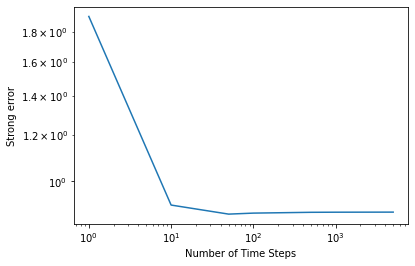

In [98]:
import matplotlib.pyplot as plt
# Define number of time steps to vary 
num_time_steps = [1, 10, 50, 100, 500, 1000, 5000]
num_samples = 10**5
# Calculate errors
errors = []
for num_steps in num_time_steps:
    errors.append(calculate_error(num_steps,num_samples))
# Plot errors as log-log plot 
plt.loglog(num_time_steps, errors) 
plt.xlabel('Number of Time Steps') 
plt.ylabel('Strong error') 
plt.show()

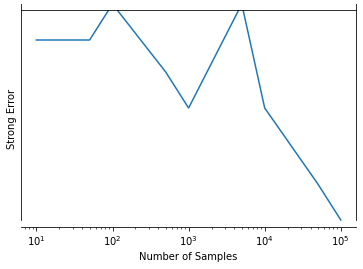

In [113]:
# Define number of samples to vary 
num_time_steps = 5000
num_samples = [10, 50, 10**2, 5*10**2, 10**3, 5*10**3, 10**4, 5*10**4, 10**5]
# Calculate errors
errors = []
for n in num_samples:
    errors.append(calculate_error(num_time_steps,n))
# Plot errors as log-log plot 
plt.loglog(num_samples, errors) 
plt.xlabel('Number of Samples') 
plt.ylabel('Strong Error') 
plt.show()

In [133]:
#errors

[0.884808419198303,
 0.884808419198303,
 0.8848084191983031,
 0.8848084191983029,
 0.8848084191983028,
 0.8848084191983031,
 0.8848084191983028,
 0.8848084191983026,
 0.8848084191983024]